In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np

from database_processing_functions import *
from create_data_matrix import *
import matplotlib.pyplot as plt

# Plot Surrogate Predictions
from gp_predict import *
from diff_evolution_col import *
import matplotlib.pyplot as plt
import seaborn as sns

# This code is to plot the surrogate model

# Load the merged_calibration_data.csv
df = pd.read_csv('merged_calibration_data.csv')

In [3]:
# Define surrogate model parameters and code

# ------
# Here, call surrogate model for flexure failure
# ------
f_surrogate_dir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\GitHub\RC_Column_Model\quoFEM_Surrogate\flexure_pd_010_just_good_data'
f_template_dir = os.path.join(f_surrogate_dir, 'templatedir_SIM')
f_surrogate_file = f_surrogate_dir + r'\SimGpModel.json'

# ------
# Here, call surrogate model for shear failure
# ------
s_surrogate_dir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\GitHub\RC_Column_Model\quoFEM_Surrogate\combined_pd_005_just_good_data'
s_template_dir = os.path.join(f_surrogate_dir, 'templatedir_SIM')
s_surrogate_file = s_surrogate_dir + r'\SimGpModel.json'

# Input_json is the same for both cases
input_json = r'C:\Users\Miguel.MIGUEL-DESK\Documents\GitHub\RC_Column_Model\quoFEM_Surrogate\scInput.json'

In [4]:
# For all the cases in the dataset, get BW model predictions from the surrogate
predicted_params = pd.DataFrame(columns = df.columns[0:14])
predicted_variances = pd.DataFrame(columns = df.columns[0:14])

for ii in range(len(df)):
    name = df['name'][ii]
    
    # Extract the calibrated and nondimensional parameters for both training and testing
    cal_params = df.iloc[ii, 0:14]
    nondim_params = df.iloc[ii, 17:23]
    
    params_list = [["RV_column1", nondim_params.iloc[0]],
               ["RV_column2", nondim_params.iloc[1]],
               ["RV_column3", nondim_params.iloc[2]],
               ["RV_column4", nondim_params.iloc[3]],
               ["RV_column5", nondim_params.iloc[4]], 
               ["RV_column6", nondim_params.iloc[5]]
               ]
    
    # Here, call surrogate model
    try:
        # Select the surrogate model
        if df['FailureType'][ii] == 'Flexure':
            # print('Flexure-type failure')
            surrogate_file = f_surrogate_file
        else:
            # print('Shear-type failure')
            surrogate_file = s_surrogate_file

        params, variance = main(params_list, [], surrogate_file, 'dummyout.out', input_json)
        params = pd.DataFrame(params, columns = df.columns[0:14])
        variance = pd.DataFrame(variance, columns = df.columns[0:14])

        predicted_params = pd.concat([predicted_params, params])
        predicted_variances = pd.concat([predicted_variances, variance])
    
    except Exception as e:
        print('Error in surrogate model', e)
        params = pd.DataFrame(np.nan*np.array(params), columns = df.columns[0:14])
        variance = pd.DataFrame(np.nan*np.array(variance), columns = df.columns[0:14])
        
        predicted_params = pd.concat([predicted_params, params])
        predicted_variances = pd.concat([predicted_variances, variance])
        continue


Error in surrogate model name 'y_pred_m_var' is not defined


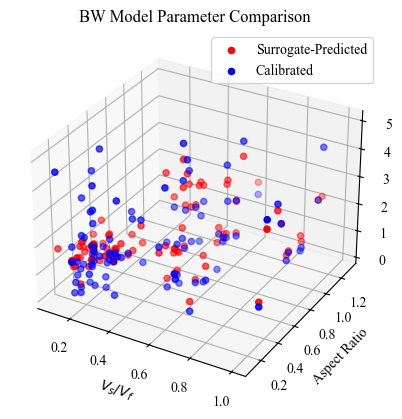

In [5]:
# Plot ar, all vs BW model predictions
# Pick two: 
# (0) ar 
# (1) lrr 
# (2) srr 
# (3) alr 
# (4) sdr
# (5) smr

xvar = 'ar'
yvar = 'smr'

xvals = df[xvar]
yvals = df[yvar]

# Select index for the parameter of interest...
par_index = 5

# Calibrated parameter
zvals = df.iloc[:, par_index]

# Surrogate prediction
bwpar = predicted_params.iloc[:, par_index]

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xvals, yvals, bwpar, c='r', marker='o', label='Surrogate-Predicted')
ax.scatter(xvals, yvals, zvals, c='b', marker='o', label='Calibrated')
ax.set_xlabel('$V_s/V_f$')
ax.set_ylabel('Aspect Ratio')
ax.set_zlabel('Parameter #6')
plt.title('BW Model Parameter Comparison')
plt.legend()

In [6]:
nondim_params_all = df.iloc[:, 17:23]
nondim_params_all.median()

ar     0.343017
lrr    0.338050
srr    0.003861
alr    0.102899
sdr    0.900000
smr    0.416794
dtype: float64

In [9]:
# Replace nans in nondim_params_all with 0
nondim_params_all = nondim_params_all.fillna(0)

Explained variance ratio: [0.95228007 0.03354297]
     Principal Component 1  Principal Component 2
0                -0.104299              -0.336684
1                -0.256628              -0.284172
2                -0.363808              -0.415754
3                -0.732307               0.415470
4                -0.504386              -0.240886
..                     ...                    ...
97               -0.762517               0.388937
98               -0.621003               0.247870
99               -0.613943               0.357225
100              -0.937218               0.433025
101              -0.940722               0.141605

[102 rows x 2 columns]


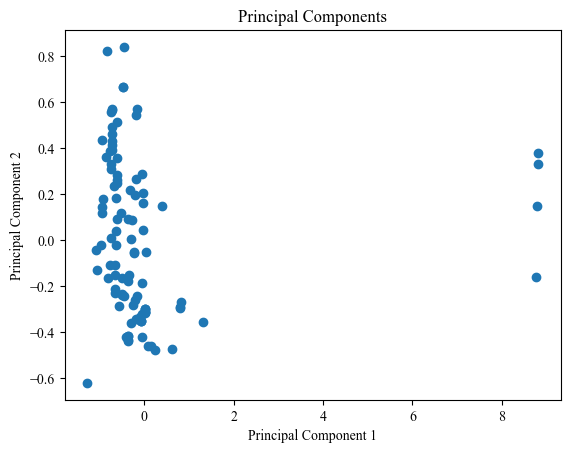

In [11]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
principal_components = pca.fit_transform(nondim_params_all)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Display the principal components
print(principal_df)

# Plot the principal components
plt.figure()
plt.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Components')
plt.show()


In [31]:
# Call PCA for a new set of parameters
# Define the new set of parameters
parameters = {
    "ar": 0.5,
    "lrr": 0.5,
    "srr": 0.5,
    "alr": 0.5,
    "sdr": 0.5,
    "smr": 0.5
}

# Get principal components of the new set of parameters

# Create a DataFrame with the new set of parameters
new_parameters_df = pd.DataFrame([parameters])

# Transform the new set of parameters into principal components
new_principal_components = pca.transform(new_parameters_df)

# Print the principal components of the new set of parameters
print("Principal components of the new set of parameters:")
print(new_principal_components)

# Inverse transform the principal components into the original parameters
new_parameters = pca.inverse_transform(new_principal_components)

# Print the original parameters
print("Original parameters:")
print(new_parameters)


Principal components of the new set of parameters:
[[-0.73111519  0.12706026]]
Original parameters:
[[0.464625   0.36509939 0.00692414 0.14310112 0.49972948 0.55013067]]


In [ ]:
# Now, lets generate a grid of values for nondimensional parameters 
from tqdm import tqdm

# Define the grid
x = np.linspace(0.01, 10, 10) # Principal component 1
y = np.linspace(0.01, 1, 10)  # Principal component 2
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)

# Evaluate the surrogate model on the values of the grid

for ii in tqdm(range(len(x))):
    for jj in range(len(y)):

        princ_comp = np.array([x[ii], y[jj]])
        # Inverse transform the principal components into the original parameters
        new_parameters = pca.inverse_transform(princ_comp.reshape(1, -1))
        
        # Generate a list of parameters
        params_list = [
            ["RV_column1", new_parameters[0][0]],
            ["RV_column2", new_parameters[0][1]],
            ["RV_column3", new_parameters[0][2]],
            ["RV_column4", new_parameters[0][3]],
            ["RV_column5", new_parameters[0][4]], 
            ["RV_column6", new_parameters[0][5]]
            ]
        
        # Generate a list of parameters
        # params_list = [["RV_column1", x[ii]],
        #        ["RV_column2", nondim_params_all.median()[1]],
        #        ["RV_column3", nondim_params_all.median()[2]],
        #        ["RV_column4", nondim_params_all.median()[3]],
        #        ["RV_column5", nondim_params_all.median()[4]], 
        #        ["RV_column6", y[jj]]
        #        ]
        
        # Simple model for classification of failure mode

        #if y[jj] > 0.8:
        #    failuretype = 'Shear'
        #else:
        #    failuretype = 'Flexure'
        failuretype = 'Flexure'

        # Here, call surrogate model
        try:
            # Select the surrogate model
            if failuretype == 'Flexure':
                # print('Flexure-type failure')
                surrogate_file = f_surrogate_file
            else:
                # print('Shear-type failure')
                surrogate_file = s_surrogate_file

            params, variance = main(params_list, [], surrogate_file, 'dummyout.out', input_json)
            params = pd.DataFrame(params, columns = df.columns[0:14])
            # variance = pd.DataFrame(variance, columns = df.columns[0:14])

            #predicted_params = pd.concat([predicted_params, params])
            #predicted_variances = pd.concat([predicted_variances, variance])
            Z[ii, jj] = params.iloc[0, par_index]

        except Exception as e:
            print('Error in surrogate model', e)
            params = pd.DataFrame(np.nan*np.array(params), columns = df.columns[0:14])
            variance = pd.DataFrame(np.nan*np.array(variance), columns = df.columns[0:14])
            
            predicted_params = pd.concat([predicted_params, params])
            predicted_variances = pd.concat([predicted_variances, variance])

            Z[ii, jj] = np.nan

            continue

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
ax.set_xlabel('ar')
ax.set_ylabel('smr')
ax.set_zlabel('bwpar')

# Add the data points
ax.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], zvals, c='r', marker='o', label='Calibrated')
ax.scatter(principal_df['Principal Component 1'], principal_df['Principal Component 2'], bwpar, c='b', marker='o', label='Surrogate-Predicted')

plt.show()



100%|██████████| 10/10 [00:16<00:00,  1.68s/it]
